# Creating Customer Segments through Unsupervised Learning

In this notebook we will analyze wholesale customer data on its internal structure. 
The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this analysis, the features `'Channel'` and `'Region'` will be excluded with focus instead on the six product categories recorded for customers.

## Getting Started
In this project, we are going to analyze a dataset containing wholesale information on various customers and their annual spending amounts (reported in *monetary units*) of diverse product categories. One goal is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so will empower the distributor with the ability to better structure their service to meet the needs of each customer such as i.e. delivery frequency.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import math
import numpy as np
import pandas as pd
import renders as rs
import pylab as plt
import seaborn as sns
from scipy.stats import pearsonr

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Set random_state number
random_state = 23

# Set color scheme
cmap = sns.diverging_palette(222, 10, as_cmap=True)

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
Let's first explore the data through visualizations and code to understand how each feature is related to the others. We will first gather a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which we will track through the course of this project for exploratory purposes.

The dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. In order to get a full understanding about what information might be hidden in the data set it helps to consider what each category represents in terms of products you could purchase. For additional insights it always helps to gather and read all [available information](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers) regarding a data set.

In [2]:
# Display a description of the numerical features of our dataset
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


#### Exploring the product categories
Based on the summary of our all numeric data set, we detect some interesting facts.
* In almost all categories, the standard deviation is surpassing the 75% quartile range. Which indicates a lot of variation and imbalance.
* The max and min values in combination with the average indicate outliers in all categories.
* Due to skewness and outliers, the mean might not be a good measure for the center point of the categories.

These observations indicate a large variance in our data set and potentially a skewed distribution. For further exploration we are computing the median for each category because it is likely a better fit for the center position of the data.

In [3]:
# Create median data points for data set
median_plt = []
for product in data.columns:
    median_plt.append(data[product].median())
    print "Products in the category " + product + " have a median value of: {:2,}".format(data[product].median())

Products in the category Fresh have a median value of: 8,504.0
Products in the category Milk have a median value of: 3,627.0
Products in the category Grocery have a median value of: 4,755.5
Products in the category Frozen have a median value of: 1,526.0
Products in the category Detergents_Paper have a median value of: 816.5
Products in the category Delicatessen have a median value of: 965.5


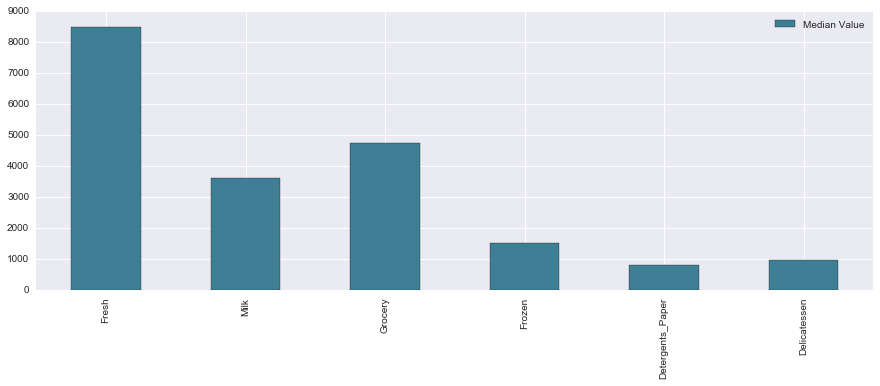

In [4]:
median_plt = pd.Series(median_plt, name='Median Value')
median_plt.index.name = 'Category'
median_plt.index = data.columns
median_plt = pd.DataFrame(median_plt)
median_plt

_ = median_plt.plot(kind='bar', figsize=(15,5), cmap=cmap)

#### Analysing product categories
Looking at the data of **customers' annual spending amounts** divided into categories there are a couple interesting observations we can make:

* People tend to buy on average the most products from the category: `Fresh` (mean > 12,000, median > 8,500)
* `Delicatessen` (median > 965.5) and `Detergents_Papers` (median > 816.5) seem to be on the lower end of the popularity spectrum 
* `Fresh`, `Milk` and `Grocery` resemble the majority of our median sales./

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [5]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [23, 42, 127]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys(), index=indices)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,26373,36423,22019,5154,4337,16523
42,10850,7555,14961,188,6899,46
127,21465,7243,10685,880,2386,2749


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

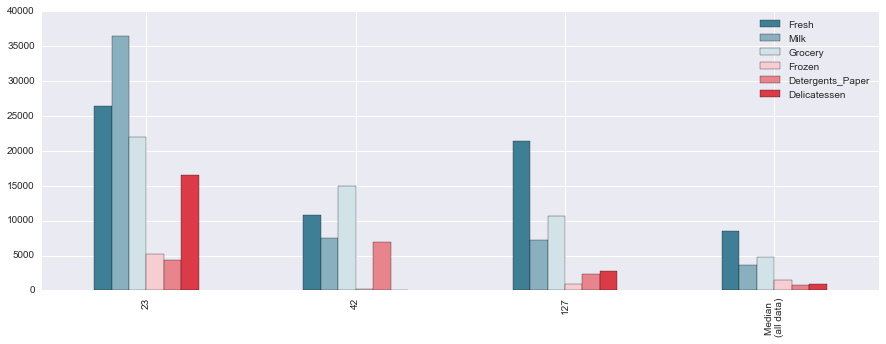

In [6]:
samples_plt = samples
samples_plt = samples_plt.append(median_plt.transpose())
samples_plt.index = indices + ['Median \n(all data)']
_ = samples_plt.plot(kind='bar', figsize=(15,5), cmap=cmap)

To get a better grasp on what the product mix for each joint looks like, we're computing the perentage of each category.

In [7]:
# Let's see what these numbers mean in relative terms
# Calculate percentage of each category
perc_list = []
for idx, category in samples.iterrows():
    customer_sum = []
    cat_sum = category.sum()
    for i in range(0,6): 
        customer_sum.append(category[i]/float(cat_sum) * 100)
    perc_list.append(customer_sum)

perc_list = pd.DataFrame(perc_list, columns=samples.columns, index=indices)
perc_list

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,23.796118,32.864142,19.867544,4.650407,3.913236,14.908553
42,26.790785,18.654782,36.941653,0.464209,17.034989,0.113583
127,47.271406,15.950934,23.531096,1.937984,5.254581,6.053999


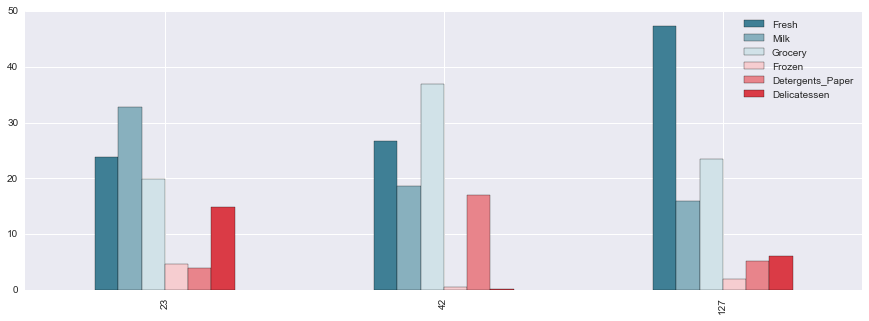

In [8]:
# Percentage plot
percentage_plt = perc_list
percentage_plt.index = indices
_ = percentage_plt.plot(kind='bar', figsize=(15,5), cmap=cmap)

**Answer:**
* **Customer 23:** This customer seems to be the largest of the three. All purchasing categories are in the upper 75% quantile and way above each category's median. This store spends an exceptionally high amount of money on products from the `Milk`, `Fresh` and `Delicatessen` categories. The most interesting piece of information is the high amount of `Milk` this customer purchases. It could represent a retailer or market that includes a broad palette of dairy products. The purchase amounts in the product categories `Delicatesen`, `Fresh` and `Milk` tend to indicate that this customer sells fresh organic high-end products with a specialty interest in Milk products. Based on its sortiment it is most likely a store that has a focus on mid- to upper-end customers.

* **Customer 42:** Customer 42's yearly purchases in the categories `Detergents_Paper`, `Fresh`, `Grocery` and `Milk` are way above the median. In fact, `Detergents`, `Grocery` and `Milk` purchases are located in the 75% quantile. Frozen lower 25 % quantile, Detergrens 75% quantile, Delicatessen low 25% quantile. With almost no product in `Delicatessen` and `Frozen` this customer seems to focus on a narrow category selection, like a corner store that's lacking space and technology for frozen products as well as a delicatessen counter.

* **Customer 127:** Customer 127 focuses on `Fresh` produce, `Milk` and `Groceries` (all 75% quantile) which indicates that we're looking at a joint that's able to turn a lot of fresh produce into profit in a small amount of time like a restaurant or a fresh produce market. The above median amount in `Delicatessen` and the below median amount in `Frozen` products indicate that there are some high-margin elements on the menu and the joint ist more likely to produce fresh meals.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
for label in data.columns:
    new_data = data.drop(label, axis = 1)
    new_data_labels = data[label]

    # TODO: Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(
        new_data, new_data_labels, test_size=0.25, random_state=random_state)

    # TODO: Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=random_state)
    regressor.fit(X_train, y_train)
    regressor.predict(X_test)
    
    # TODO: Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    
    print "Prediction score for " + label + " (R^2): " + str(score)

Prediction score for Fresh (R^2): -1.07567741497
Prediction score for Milk (R^2): 0.493870361639
Prediction score for Grocery (R^2): 0.718409124285
Prediction score for Frozen (R^2): -0.0454090784171
Prediction score for Detergents_Paper (R^2): 0.793049741582
Prediction score for Delicatessen (R^2): 0.027209862392


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** 

To get a better insight in the relevance of each category for understanding a customer's purchasing preferences, we selected each category, dropped it from the data set and tried to predict its values based on the remaining categories. The Decision Tree Regressor failed to predict `Fresh` and `Frozen` (indicated through a negative R^2 score) and had difficulties predicting `Delicatessen`. Which means all these categories are important. The R^2 scores for `Grocery` and `Detergents_Paper` (both above .7) show that these two categories were quite predictable based on the other categories. `Milk` with an R^2 score below .5 is in between.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

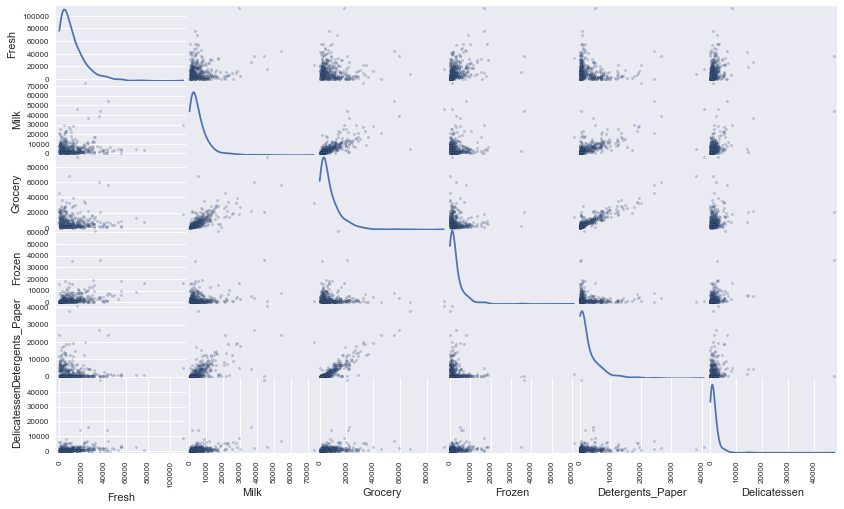

In [10]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde', cmap=cmap);

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

**Data distribution:**

The data is not normally distributed, the density plots show that all categories have a high positive skew. 

**Correlation:**

Based on the visual cues, following pairs seem to exhibit some degree of correlation:
* Milk and Grocery
* Milk and Detergents_Paper
* Grocery and Detergents_Paper

In order to validate this, let's take a look at a correlation map:

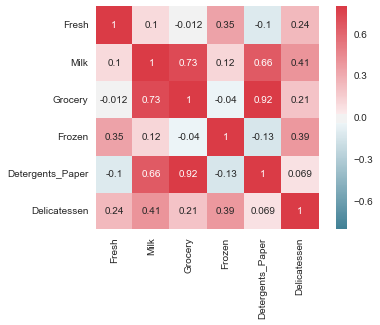

In [11]:
_ = sns.heatmap(data.corr(), annot=True, vmax=.8, square=True, cmap=cmap)

In [12]:
def corr_table(data, features, sig_level=0.05, strength=0.0):
    p_val_dict = []
    check_dict = []
    for feature in features:
        for label in features:
            # Since these correlations go in both directions, we only need to store on 
            # of the correlations and can discard the secon one
            # i.e. corr(age, Medu) has equal insights to corr(Medu, age)
            feature_comb = label+feature
            
            if feature == label or feature_comb in check_dict:
                #feature is already paired with label or equals label
                continue
            else:
                check_dict.append(feature+label)
                pears = pearsonr(data[feature], data[label])
                p_val = pears[1]
                corr_strength = pears[0]
                cov_strength = np.cov(data[feature], data[label])[0][1]
                
                # Check if correlation is significant and has a high enough correlation
                if p_val < sig_level and math.fabs(corr_strength) > strength:
                    p_val_dict.append([feature, label, cov_strength, corr_strength, p_val])

    p_corr_title = 'Correlation > ' + str(strength)
    p_value_title = 'p-Value < ' + str(sig_level)
    p_val_dict = pd.DataFrame(p_val_dict, columns = ['Feature', 'Label', 'Covariance', p_corr_title, p_value_title])
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    return p_val_dict

correlations_all = corr_table(data, data[:-1], strength=0.2)
print 'There are {} significant correlations in the data set. (< {} p-Value, > {} correlation strength)'.format(
    len(correlations_all), .05, .2)

correlations_all['AbsCor'] = correlations_all.ix[:,3].abs()
correlations_all = correlations_all.sort_values('AbsCor', ascending = False)
correlations_all[correlations_all.columns.tolist()[0:5]]

There are 8 significant correlations in the data set. (< 0.05 p-Value, > 0.2 correlation strength)


,Feature,Label,Covariance,Correlation > 0.2,p-Value < 0.05
5,Grocery,Detergents_Paper,41895189.6875,0.9246,0.0000
2,Milk,Grocery,51083186.3065,0.7283,0.0000
3,Milk,Detergents_Paper,23288343.4813,0.6618,0.0000
4,Milk,Delicatessen,8457924.7976,0.4064,0.0000
7,Frozen,Delicatessen,5352341.7611,0.3909,0.0000
0,Fresh,Frozen,21236654.5853,0.3459,0.0000
1,Fresh,Delicatessen,8727309.9703,0.2447,0.0000
6,Grocery,Delicatessen,5507291.2706,0.2055,0.0000


In fact, the visual cues were correct. The 3 strongest correlations are between the earlier mentioned categories:

* Grocery and Detergents_Paper
* Milk and Grocery
* Milk and Detergents_Paper

The categories `Fresh`, `Frozen` and `Delicatessen` which the Decision Tree Regressor was unable to predict correctly have weaker significant correlation with other features but not enough relationship strength in between to be picked up by the regression algorithm correctly. 

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

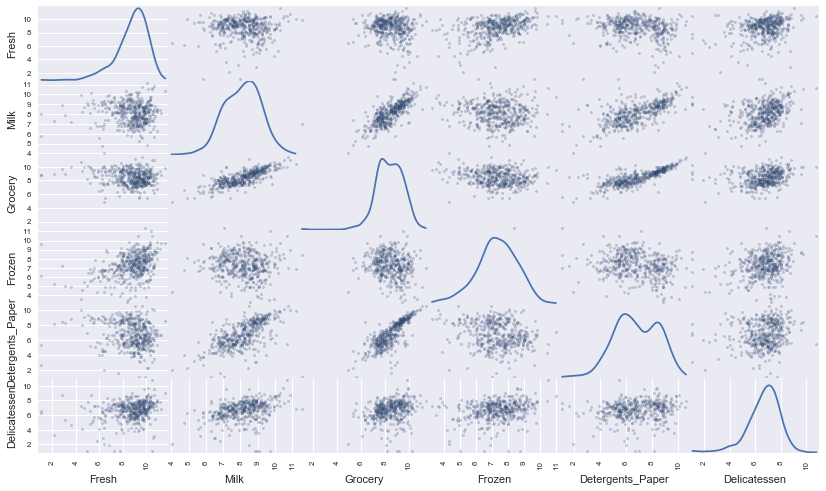

In [13]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data.copy())

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples.copy())

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde', cmap=cmap);

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [14]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,10.1801,10.5030,9.9997,8.5475,8.3749,9.7125
42,9.2919,8.9300,9.6132,5.2364,8.8391,3.8286
127,9.9742,8.8878,9.2766,6.7799,7.7774,7.9190


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [15]:
outliers = {}
outliers_all = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    category_outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    for outlier_no in category_outliers.index:
        if outlier_no in outliers:
            outliers[outlier_no] += 1
        else:
            outliers[outlier_no] = 1
            outliers_all.append(outlier_no)
    display(category_outliers)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.4427,9.9503,10.7327,3.5835,10.0954,7.2605
66,2.1972,7.3356,8.9115,5.1648,8.1513,3.2958
81,5.3891,9.1632,9.5752,5.6454,8.9642,5.0499
95,1.0986,7.9793,8.7407,6.0868,5.4072,6.5639
96,3.1355,7.8694,9.0018,4.9767,8.2620,5.3799
128,4.9416,9.0878,8.2488,4.9558,6.9679,1.0986
171,5.2983,10.1605,9.8942,6.4785,9.0794,8.7403
193,5.1930,8.1562,9.9180,6.8659,8.6337,6.5013
218,2.8904,8.9232,9.6294,7.1585,8.4757,8.7597
304,5.0814,8.9173,10.1175,6.4249,9.3744,7.7874


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.0400,11.2050,10.3770,6.8947,9.9070,6.8057
98,6.2206,4.7185,6.6567,6.7968,4.0254,4.8828
154,6.4329,4.0073,4.9200,4.3175,1.9459,2.0794
356,10.0295,4.8978,5.3845,8.0574,2.1972,6.3063


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.9232,7.0361,1.0986,8.3909,1.0986,6.8824
154,6.4329,4.0073,4.9200,4.3175,1.9459,2.0794


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.4319,9.6633,9.7237,3.4965,8.8474,6.0707
57,8.5973,9.2036,9.2579,3.6376,8.9322,7.1562
65,4.4427,9.9503,10.7327,3.5835,10.0954,7.2605
145,10.0006,9.0341,10.4571,3.7377,9.4407,8.3962
175,7.7592,8.9676,9.3821,3.9512,8.3419,7.4366
264,6.9782,9.1777,9.6450,4.1109,8.6962,7.1428
325,10.3957,9.7282,9.5197,11.0165,7.1483,8.6321
420,8.4020,8.5690,9.4900,3.2189,8.8273,7.2392
429,9.0603,7.4674,8.1831,3.8501,4.4308,7.8244
439,7.9327,7.4372,7.8280,4.1744,6.1675,3.9512


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.9232,7.0361,1.0986,8.3909,1.0986,6.8824
161,9.4282,6.2916,5.6454,6.9958,1.0986,7.7111


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.1972,7.3356,8.9115,5.1648,8.1513,3.2958
109,7.2485,9.7249,10.2746,6.5117,6.7286,1.0986
128,4.9416,9.0878,8.2488,4.9558,6.9679,1.0986
137,8.0350,8.9971,9.0218,6.4938,6.5806,3.5835
142,10.5196,8.8751,9.0183,8.0047,2.9957,1.0986
154,6.4329,4.0073,4.9200,4.3175,1.9459,2.0794
183,10.5145,10.6908,9.9120,10.5060,5.4765,10.7778
184,5.7900,6.8222,8.4574,4.3041,5.8111,2.3979
187,7.7989,8.9874,9.1921,8.7434,8.1487,1.0986
203,6.3682,6.5294,7.7035,6.1506,6.8607,2.8904


#### Multi-Category Outliers
Let's have a look at the outliers, that are outliers in more than one category:

In [16]:
outliers_multiple = {k for k,v in outliers.iteritems() if v > 1}
outliers_multiple = [k for k,v in outliers.iteritems() if v > 1]
print "Outliers in multiple categories: " + str([x for x in outliers_multiple])
print "(Count: " + (str(len(outliers_multiple))) + ")"

Outliers in multiple categories: [128, 154, 65, 66, 75]
(Count: 5)


#### Removing outliers
In order to clean the data, we'll be removing all outliers from our data set.

In [17]:
outliers_all = {k for k,v in outliers.iteritems()}
outliers_all = [x for x in outliers_all]
print "All outliers: " + str(outliers_all)
print "(Count: " + (str(len(outliers_all))) + ")"

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers_all]).reset_index(drop = True)

All outliers: [128, 65, 264, 137, 142, 145, 154, 412, 285, 161, 420, 38, 171, 429, 175, 304, 305, 439, 184, 57, 187, 193, 66, 75, 325, 289, 203, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109, 183]
(Count: 42)


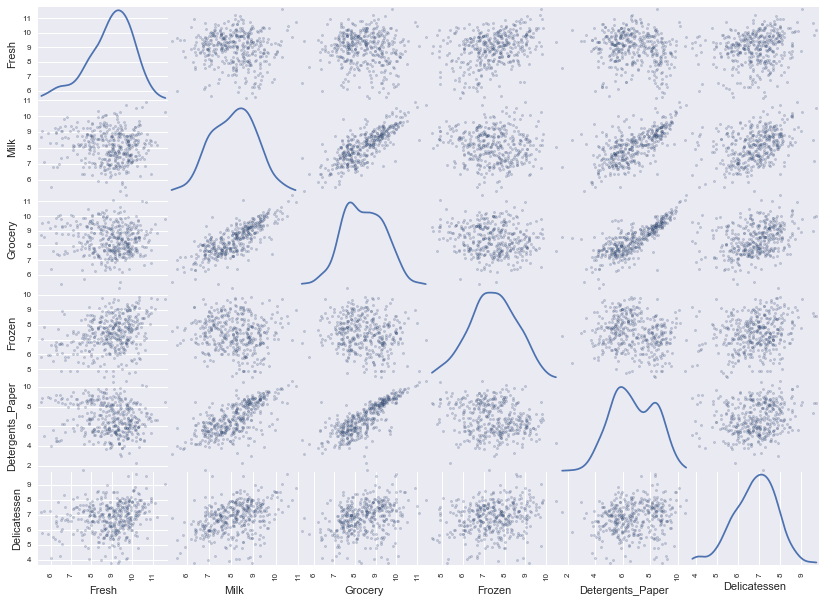

In [18]:
# Plot scatter matrix without outliers
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde', cmap=cmap);

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** 

Based on our outlier definition, there are 5 data points that appear as an outlier in more than one category. Before removing the outliers our data set experienced actually a negative skew, which indicated that even through normalization we weren't able to get a normal distribution. In order to correct this we removed all outlier data points. After doing so, the `good_data` set is close to normal distributed. The correlations we detected earlier are more clear as well and the data set looks more balanced. 

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

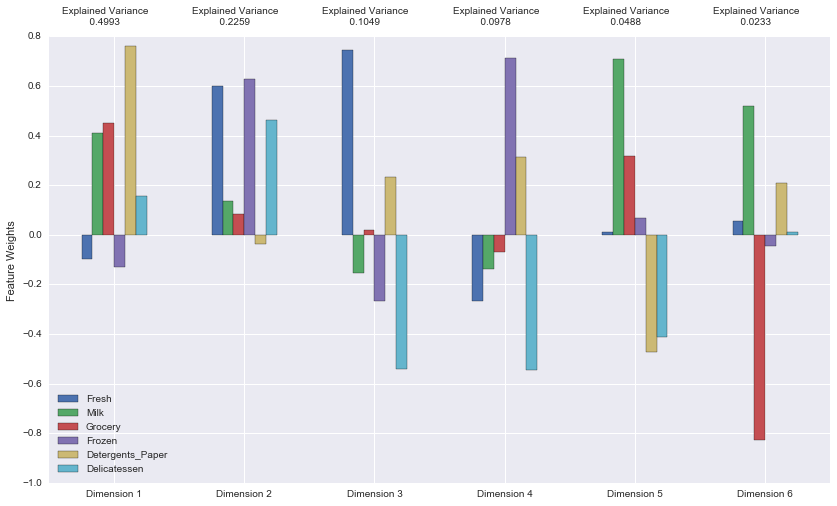

In [19]:
from sklearn.decomposition import PCA
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca = pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

In [20]:
pd.DataFrame(data=[np.cumsum(pca.explained_variance_ratio_)], columns="Add " + 
             pca_results.index.values, index=['Combined Explained Variance'])

,Add Dimension 1,Add Dimension 2,Add Dimension 3,Add Dimension 4,Add Dimension 5,Add Dimension 6
Combined Explained Variance,0.4993,0.7253,0.8301,0.9280,0.9767,1.0000


**Answer:** 

The first and the second principal components are explaining over **72.5 %** of the variance. If Dimension 3 and 4 are added to the mix, this value goes up to over **92.7 %**.
* As suggested earlier, `Milk`, `Grocery` and `Detergents_Paper` have a high correlation, this is represented by the first principal component `Detergents_Paper` being the feature with the highest correlation. 
* The second principal component features a positive relationship between `Fresh`, `Frozen` and `Delicatessen`
* The third principal component introduces a negative correlation between the combination of `Fresh` and `Detergents_Paper` on the one side and `Delicatessen`, `Milk` plus `Frozen` on  the other side.
* The fourth principal component suggests a relationship between `Frozen` and `Detergents_Paper` vs. `Delicatessen`, `Fresh`, `Milk` and `Grocery`.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [21]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values,index=[indices]))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
23,3.0921,3.2039,-0.9108,-1.0586,0.3270,0.2987
42,2.2059,-2.4083,2.8456,0.4106,1.0626,-0.0472
127,1.6118,0.8751,0.4744,-1.2032,-0.1456,-0.0089


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [22]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca = pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [23]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2'], index=indices))

,Dimension 1,Dimension 2
23,3.0921,3.2039
42,2.2059,-2.4083
127,1.6118,0.8751


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

In general K-Means can be seen as a special case of a Gaussian Mixture Model in which each cluster's covariance along all dimensions approaches 0. This means, each data point will be assigned to exactly one cluster. A Gaussian Mixture Model is a more bayesian approach to clustering. It introduces the ability of soft clustering, which means that data points can be part of more than one cluster. The algorithm also calculates the probability of the data point belonging to a certain center. Below are the key advantages of both models, based on [this](http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html) and [this](https://sites.google.com/site/dataclusteringalgorithms/k-means-clustering-algorithm) resource:

**Advantages K-Means:**
* Robust and easy to understand.
* Relatively computational efficient. 
* Delivers a great result when data points are distinct or groups within are well separated from each other.

**Advantages GMM:**
* Allows "soft" classifications.
* Delivers a density estimation for each cluster.
* Flexibility in choosing the component distribution.
* Reflects real-world scenarios in a good way.

Because we're dealing with a real world scenario and a data set where it sometimes might be hard to distinguish between data points, we'll go ahead with a GMM implementation. This will also give us the opportunity to soft-label our data-points and refine the clustering at a later point. With around 450 data points we don't have to be concerned about speed.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [24]:
from sklearn import mixture
from sklearn.metrics import silhouette_score
# TODO: Apply your clustering algorithm of choice to the reduced data 

score_list = []
score_columns = []
for n in range(7,1,-1):
    clusterer = mixture.GMM(n_components=n)
    clusterer.fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    score_list.append(score)
    score_columns.append(str(n) + " components")


score_list = pd.DataFrame(data=[score_list],columns=score_columns, index=['Silhouette Score'])
score_list

,7 components,6 components,5 components,4 components,3 components,2 components
Silhouette Score,0.2796,0.3093,0.2679,0.2923,0.3573,0.4436


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** 

We tried to calculate the silhouette score for component amounts ranging from 2 to 7. A setup with 2 components had the best score (**0.444**) and we'll be using this setup down the road as our number of clusters.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

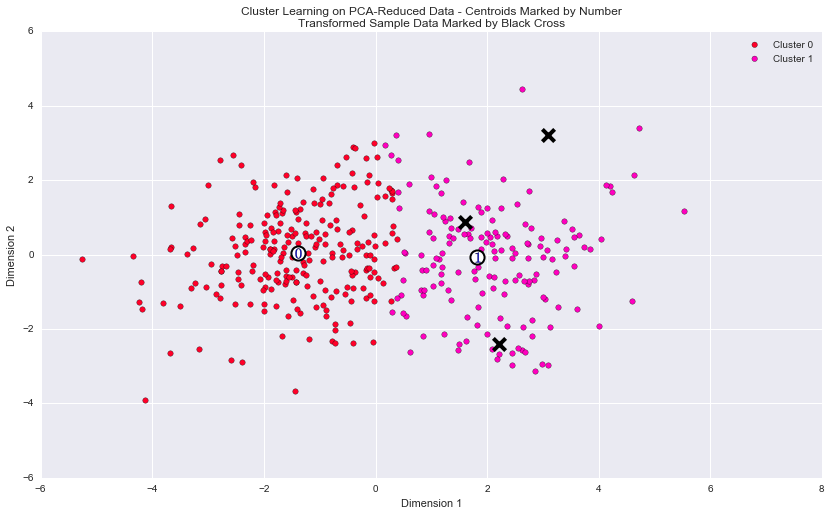

In [25]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [26]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8967.0000,1920.0000,2437.0000,2081.0000,309.0000,741.0000
Segment 1,6079.0000,7042.0000,10241.0000,1275.0000,3546.0000,1159.0000


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

To categorize our examples into two segments it will help to look at the median values for each category and rethink our initial exploration of the sample cases.

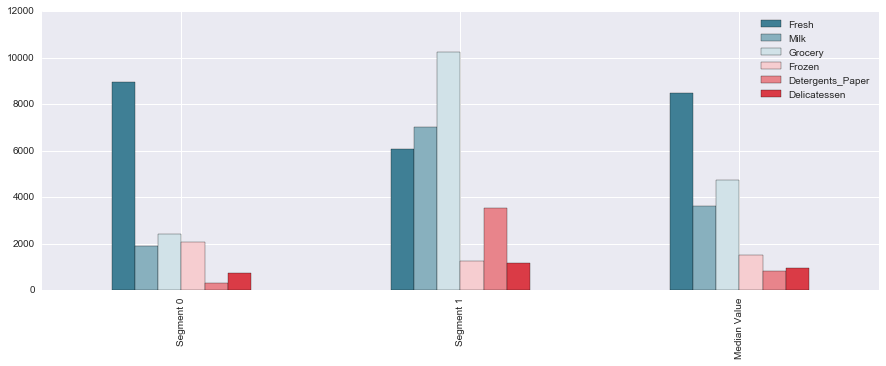

In [27]:
_ = true_centers.append(median_plt.transpose()).plot(kind='bar', figsize=(15,5), cmap=cmap)

* **Segment 0:** Above median categories for this segment are `Fresh` and `Frozen` with `Fresh` being by far the largest category in the product mix. The center of this cluster is placed more towards smaller accounts on the two chosen dimensions. This segment seems to be heavily reliant on the freshness of its products and we could potentially label these as restaurants.
* **Segment 1:** Looking at the values and plots it seems that Segment 0 is representing larger accounts. Above median categories are `Grocery`, `Milk`, `Fresh` and `Detergents_Paper` with `Grocery` being the largest category in the product mix. Customers in this segment could be retail stores and accounts that handle a certain volume of product. Due to a more balanced product mix this segment seems to represent retailers with bigger accounts.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [28]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


In [29]:
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,26373,36423,22019,5154,4337,16523
42,10850,7555,14961,188,6899,46
127,21465,7243,10685,880,2386,2749


**Answer:**

Overall these predictions seem reasonable. As mentioned earlier all these accounts have multiple above median categories. Especially the combination of `Fresh`, `Grocery`, `Milk` and `Detergents_Paper` seems to classify these sample points quite nicely. The only candidate where there might be potential for discussion is customer 127. Customer 127 seems to be a close prediction that could have potentially panned out the other way with a large amount of fresh products compared to the other features.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

The principle of A/B testing can be helpful in order to measure how changes in a service or product will affect the customer base. A/B testing generally changes a product or service on one feature to test the effect on this change on a random selected sample of users.

Since we were able to create two clusters of accounts with different spending habits and needs we can now use this information to fine-tune experiments about the service we are offering. 

In our case with two variants, A and B, which are the control and variation A would resemble the status-quo (5 days/week delivery) and B resembles a 3 day/week delivery norm. To understand and measure how each of our customer segments is reacting on the change we would perform the A/B test as follows:

1. Determin `control` version A (Shipping 5 days a week)
2. Determin `treatment` B (Shipping 3 days a week)
3. Pick two randomly selected sample sets of similar size from each segment. (Seg1 & Seg2)
4. Split each sample set in two sets of equal size (Seg1.A, Seg1.B & Seg2.A, Seg2.B)
5. Use control version on each one segment sub-split (Seg1.A & Seg2.A)
6. At the same time use treatment version on the corresponding segment sub-split (Seg1.B & Seg2.B)
7. Measure significance of effect through Welch's t-test

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:** Since we can classify our customers in two clusters (Segment 0 and Segment 1 or Retailers and Restaurants) we could now use a supervised learning classifier such as Logistic Regression or Support Vector Machine to train on this data. The target variable would be `customer_segment` given our algorithm a label to train on. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

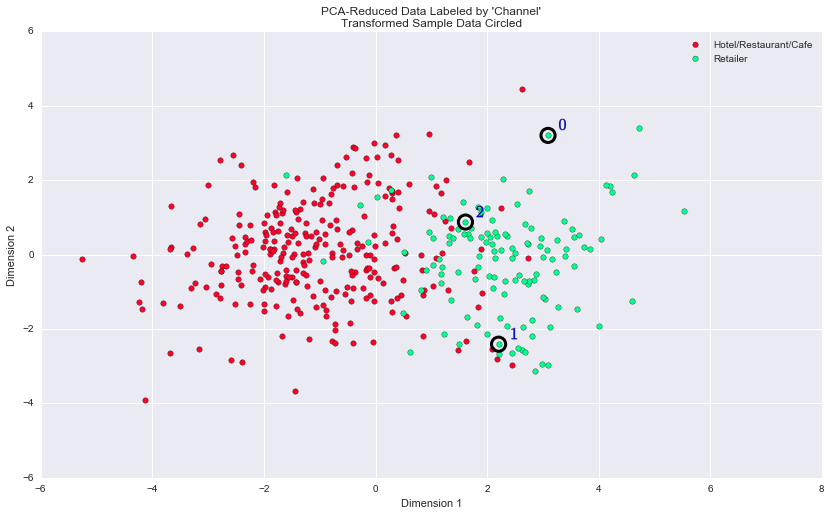

In [30]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers_all, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** 

The number of clusters is the correct amount. The original channel distribution is split up in two catefories as well. The image indicates clearly, that there is some overlap in the data which means that a clustering algorithm might get problems classifying correctly through the reduction to these two dimensions. As mentioned earlier, one of the big drawbacks for K-Means clustering is that it needs a data set which is distinct or has groups within that are well separated from each other. Therefore the usage of a GMM clustering algorithm that offers the ability to soft cluster is helpful for cases such as this. The classification for our test cases (including customer 127 that seemed a bit ambivalent at first) and the majority of the data points seem to be classified correctly but there are cases that make it hard to distinguish between restaurants and retailers. This makes sense as well, since the traditional product mix for either of these categories changed over the years with more individual shop concepts or i.e. the rise of the organic food movement and retailers taking over restaurant domains with sandwich counters, organic fast-food solutions or convenient food.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.